# 1. Imports and Set Up

In [1]:
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from scripts.classification_utils import *
from scripts.visualization_utils import *
from scripts.evaluation_utils import *
import csv
import os
from itertools import zip_longest
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, EqualizedOdds, \
    TruePositiveRateParity, FalsePositiveRateParity, ErrorRateParity, BoundedGroupLoss
from fairlearn.metrics import *
from raiwidgets import FairnessDashboard
%matplotlib inline

# 0. IMPORTANT--Specify classifier to be trained and dataset

In [2]:
models = {'Decision Tree': 'dt', 'Gaussian Naive Bayes':'gnb','Logistic Regression': 'lgr', 'Gradient_Boosted_Trees': 'gbt'}
#constraints = {'DemograficParity': 'DP', 'DemograficParity': 'EO', 'DemograficParity': 'EOO', 'DemograficParity': 'FPRP', 'DemograficParity': 'ERP'}
#reduction_algorithms = {'Exponential Gradient':'EG','Grid Search':'GS'}

data_path = '../data/final/balanced_set_100_42.csv'
results_path = '../data/results/notebook/'
model_name = models['Logistic Regression']
weight_idx = 1
testset_size = 0.3
save = True

In [3]:
try:
    os.mkdir(f'../data/results/notebook/{model_name}')
except:
    print("Folder exists")

Folder exists


In [4]:
models_dict = {}
overall_results_dict = {}
black_results_dict = {}
white_results_dict = {}
all_scores = []
scores_names = []

# 2. Prepare data

In [5]:
data = get_data(data_path)

In [6]:
print(type(data))
print(data)

<class 'pandas.core.frame.DataFrame'>
       score  repay_probability  race  repay_indices
0        682              94.06     1              1
1        710              96.25     1              1
2        468              11.05     0              0
3        689              94.78     1              1
4        782              98.50     1              1
...      ...                ...   ...            ...
99995    367               3.38     0              0
99996    456              16.67     1              0
99997    689              94.78     1              1
99998    324               1.20     0              0
99999    444               9.54     0              0

[100000 rows x 4 columns]


In [7]:
X_train, X_test, y_train, y_test, race_train, race_test, sample_weight_train, sample_weight_test = prep_data(data=data, test_size=testset_size, weight_index=weight_idx)

In [8]:
# split up X_test by race
X_test_b = []

X_test_w = []

for index in range(len(X_test)):
    if race_test[index] == 0:  # black
        X_test_b.append(X_test[index][0])
    elif race_test[index] == 1:  # white
        X_test_w.append(X_test[index][0])

# given predictions+outcomes, I'll need to do the same 

In [9]:
#adding scores to list
all_scores.extend([X_test_b,X_test_w])
scores_names.extend(['testB', 'testW'])

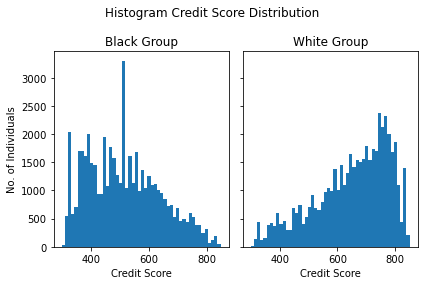

In [10]:
# make histogram of credit scores by race
visual_scores_by_race(data)

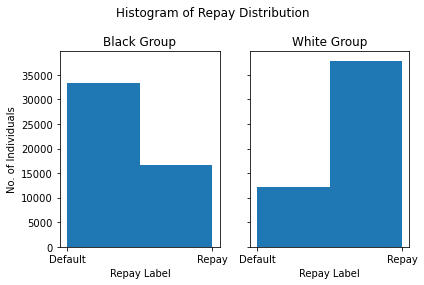

In [11]:
visual_repay_dist(data)

# 3. Classifier

In [12]:
print('The classifier trained below is: ', model_name)

results_path += f'{model_name}/'

The classifier trained below is:  lgr


In [13]:
classifier = get_classifier(model_name)

## Train classifier and collect predictions
NOTE: atm sample_weight are all 1s

In [14]:
# Reference: https://www.datacamp.com/community/tutorials/decision-tree-classification-python
np.random.seed(0)

# Train the classifier:
model = classifier.fit(X_train,y_train, sample_weight_train)

# Make predictions with the classifier:
y_predict = model.predict(X_test)

# Scores on test set
test_scores = model.predict_proba(X_test)[:, 1]

### Get new scores by race

In [15]:
# think: later on I might want to create a sheet just with the TP and FP scores by race specifically
X_unmit_b, X_unmit_w,_,_ = get_new_scores(X_test, y_predict, y_test, race_test)

In [16]:
#adding scores to list
all_scores.extend([X_unmit_b,X_unmit_w])
scores_names.extend(['unmitB', 'unmitW'])

### Evaluation of classifier overall

In [17]:
# Metrics
models_dict = {"Unmitigated": (y_predict, test_scores)}
get_metrics_df(models_dict, y_test, race_test)

,Unmitigated
Overall selection rate,0.5495
Demographic parity difference,0.492266
Demographic parity ratio,0.380089
------,
Overall balanced error rate,0.134763
Balanced error rate difference,0.00817
------,
True positive rate difference,0.228065
True negative rate difference,0.211726
False positive rate difference,0.211726


### Cross-validated metrics

In [18]:
x = data[['score', 'race']].values
y = data['repay_indices'].values

In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, x, y, cv=5, scoring='f1_weighted')
print(scores)

[0.86526894 0.86415852 0.86367458 0.87229634 0.86139744]


### Delayed impact calculated
### Fairness Metric Evaluation of classifier
### Evaluation of classifier by race

In [20]:
constraint_str = 'Un-'
results_overall, results_black, results_white = evaluating_model(constraint_str,X_test,y_test, y_predict, sample_weight_test,race_test)

### Save results to dictionaries

In [21]:
run_key = f'{model_name} Unmitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [86.65, '[[11505  1994]\n [ 2010 14491]]', 86.65, 86.65, 87.86, 54.95, 85.23, 87.82, 12.18, 14.77, 8.290889574667919, 38.84192394328873, 49.23, 22.81, 22.81, 21.17, 4.26]}
{'lgr Unmitigated': [84.51, '[[9004  906]\n [1403 3593]]', 84.51, 84.29, 75.68, 30.18, 90.86, 71.92, 28.08, 9.14, 8.29]}
{'lgr Unmitigated': [88.77, '[[ 2501  1088]\n [  607 10898]]', 88.77, 88.48, 92.78, 79.41, 69.69, 94.72, 5.28, 30.31, 38.84]}


## Exponentiated Gradient Reduction Alg for Adding Fairness Constraints

In [22]:
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 60em; }</style>"))

### Demographic Parity

In [23]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'DP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [24]:
### Get new scores by race
X_egDP_b, X_egDP_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [25]:
#adding scores to list
all_scores.extend([X_egDP_b, X_egDP_w])
scores_names.extend(['egdpB', 'egdpW'])

### Save results to dictionaries

In [26]:
run_key = f'{model_name} EG DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [86.65, '[[11505  1994]\n [ 2010 14491]]', 86.65, 86.65, 87.86, 54.95, 85.23, 87.82, 12.18, 14.77, 8.290889574667919, 38.84192394328873, 49.23, 22.81, 22.81, 21.17, 4.26], 'lgr EG DP Mitigated': [74.86, '[[ 9149  4350]\n [ 3191 13310]]', 74.86, 74.73, 77.93, 58.87, 67.78, 80.66, 19.34, 32.22, -18.245404535086543, 35.766198489466014, 1.65, 32.43, 16.45, 32.43, 9.26]}
{'lgr Unmitigated': [84.51, '[[9004  906]\n [1403 3593]]', 84.51, 84.29, 75.68, 30.18, 90.86, 71.92, 28.08, 9.14, 8.29], 'lgr EG DP Mitigated': [70.21, '[[5862 4048]\n [ 393 4603]]', 70.21, 70.83, 67.46, 58.04, 59.15, 92.13, 7.87, 40.85, -18.25]}
{'lgr Unmitigated': [88.77, '[[ 2501  1088]\n [  607 10898]]', 88.77, 88.48, 92.78, 79.41, 69.69, 94.72, 5.28, 30.31, 38.84], 'lgr EG DP Mitigated': [79.46, '[[3287  302]\n [2798 8707]]', 79.46, 80.86, 84.89, 59.69, 91.59, 75.68, 24.32, 8.41, 35.77]}


### Equalized Odds

In [27]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'EO', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [28]:
X_egEO_b, X_egEO_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [29]:
#adding scores to list
all_scores.extend([X_egEO_b, X_egEO_w])
scores_names.extend(['egeoB', 'egeoW'])

### Save results to dictionaries

In [30]:
run_key = f'{model_name} EG EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [86.65, '[[11505  1994]\n [ 2010 14491]]', 86.65, 86.65, 87.86, 54.95, 85.23, 87.82, 12.18, 14.77, 8.290889574667919, 38.84192394328873, 49.23, 22.81, 22.81, 21.17, 4.26], 'lgr EG DP Mitigated': [74.86, '[[ 9149  4350]\n [ 3191 13310]]', 74.86, 74.73, 77.93, 58.87, 67.78, 80.66, 19.34, 32.22, -18.245404535086543, 35.766198489466014, 1.65, 32.43, 16.45, 32.43, 9.26], 'lgr EG EO Mitigated': [83.72, '[[11042  2457]\n [ 2427 14074]]', 83.72, 83.72, 85.21, 55.1, 81.8, 85.29, 14.71, 18.2, 1.4781966993157118, 38.98688220484961, 28.14, 3.35, 1.44, 3.35, 3.34]}
{'lgr Unmitigated': [84.51, '[[9004  906]\n [1403 3593]]', 84.51, 84.29, 75.68, 30.18, 90.86, 71.92, 28.08, 9.14, 8.29], 'lgr EG DP Mitigated': [70.21, '[[5862 4048]\n [ 393 4603]]', 70.21, 70.83, 67.46, 58.04, 59.15, 92.13, 7.87, 40.85, -18.25], 'lgr EG EO Mitigated': [82.04, '[[8018 1892]\n [ 785 4211]]', 82.04, 82.41, 75.88, 40.94, 80.91, 84.29, 15.71, 19.09, 1.48]}
{'lgr Unmitigated': [88.77, '[[ 2501  1088]\n [  

### EOO (True Positive Rate Parity)

In [31]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'TPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [32]:
X_egEOO_b, X_egEOO_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [33]:
#adding scores to list
all_scores.extend([X_egEOO_b, X_egEOO_w])
scores_names.extend(['egeooB', 'egeooW'])

### Save results to dictionaries

In [34]:
run_key = f'{model_name} EG EOO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [86.65, '[[11505  1994]\n [ 2010 14491]]', 86.65, 86.65, 87.86, 54.95, 85.23, 87.82, 12.18, 14.77, 8.290889574667919, 38.84192394328873, 49.23, 22.81, 22.81, 21.17, 4.26], 'lgr EG DP Mitigated': [74.86, '[[ 9149  4350]\n [ 3191 13310]]', 74.86, 74.73, 77.93, 58.87, 67.78, 80.66, 19.34, 32.22, -18.245404535086543, 35.766198489466014, 1.65, 32.43, 16.45, 32.43, 9.26], 'lgr EG EO Mitigated': [83.72, '[[11042  2457]\n [ 2427 14074]]', 83.72, 83.72, 85.21, 55.1, 81.8, 85.29, 14.71, 18.2, 1.4781966993157118, 38.98688220484961, 28.14, 3.35, 1.44, 3.35, 3.34], 'lgr EG EOO Mitigated': [83.92, '[[10996  2503]\n [ 2320 14181]]', 83.92, 83.91, 85.47, 55.61, 81.46, 85.94, 14.06, 18.54, 1.015295854018516, 39.4282496356168, 27.86, 4.46, 1.39, 4.46, 4.13]}
{'lgr Unmitigated': [84.51, '[[9004  906]\n [1403 3593]]', 84.51, 84.29, 75.68, 30.18, 90.86, 71.92, 28.08, 9.14, 8.29], 'lgr EG DP Mitigated': [70.21, '[[5862 4048]\n [ 393 4603]]', 70.21, 70.83, 67.46, 58.04, 59.15, 92.13, 7.87

### False Positive Rate Parity

In [35]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'FPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [36]:
X_egFPRP_b, X_egFPRP_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [37]:
#adding scores to list
all_scores.extend([X_egFPRP_b, X_egFPRP_w])
scores_names.extend(['egfprpB', 'egfprpW'])

### Save results to dictionaries

In [38]:
run_key = f'{model_name} EG FPRP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

{'lgr Unmitigated': [86.65, '[[11505  1994]\n [ 2010 14491]]', 86.65, 86.65, 87.86, 54.95, 85.23, 87.82, 12.18, 14.77, 8.290889574667919, 38.84192394328873, 49.23, 22.81, 22.81, 21.17, 4.26], 'lgr EG DP Mitigated': [74.86, '[[ 9149  4350]\n [ 3191 13310]]', 74.86, 74.73, 77.93, 58.87, 67.78, 80.66, 19.34, 32.22, -18.245404535086543, 35.766198489466014, 1.65, 32.43, 16.45, 32.43, 9.26], 'lgr EG EO Mitigated': [83.72, '[[11042  2457]\n [ 2427 14074]]', 83.72, 83.72, 85.21, 55.1, 81.8, 85.29, 14.71, 18.2, 1.4781966993157118, 38.98688220484961, 28.14, 3.35, 1.44, 3.35, 3.34], 'lgr EG EOO Mitigated': [83.92, '[[10996  2503]\n [ 2320 14181]]', 83.92, 83.91, 85.47, 55.61, 81.46, 85.94, 14.06, 18.54, 1.015295854018516, 39.4282496356168, 27.86, 4.46, 1.39, 4.46, 4.13], 'lgr EG FPRP Mitigated': [84.8, '[[11173  2326]\n [ 2233 14268]]', 84.8, 84.8, 86.22, 55.31, 82.77, 86.47, 13.53, 17.23, 2.902119951697303, 39.756194514376574, 31.63, 4.82, 4.82, 0.51, 4.0]}
{'lgr Unmitigated': [84.51, '[[9004  9

### Error Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'ERP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
X_egERP_b, X_egERP_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_egERP_b, X_egERP_w])
scores_names.extend(['egerpB', 'egerpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} EG ERP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

## Grid Search Reduction Alg for Adding Fairness Constraints

### Demographic Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'DP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

The next few cells come from: https://github.com/fairlearn/fairlearn/blob/main/notebooks/Binary%20Classification%20with%20the%20UCI%20Credit-card%20Default%20Dataset.ipynb

Note: we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric.

In [ ]:
grid_search_show(mitigator, demographic_parity_difference, y_pred_mitigated, X_test, y_test, race_test, 'DemParityDifference','GS DPD', models_dict, 0.3)

In [ ]:
models_dict.pop('GS DPD')
models_dict

### Get new scores by race

In [ ]:
X_gsDP_b, X_gsDP_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_gsDP_b, X_gsDP_w ])
scores_names.extend(['gsdpB', 'gsdpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Equalized Odds Used

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'EO', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
grid_search_show(mitigator, equalized_odds_difference, y_pred_mitigated, X_test, y_test, race_test, 'EOddsDifference','GS EO', models_dict, 0.3)

In [ ]:
models_dict.pop('GS EO')
models_dict

### Get new scores by race

In [ ]:
X_gsEO_b, X_gsEO_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_gsEO_b, X_gsEO_w])
scores_names.extend(['gseoB', 'gseoW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### EOO (True Positive Rate Parity)

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'TPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
grid_search_show(mitigator, true_positive_rate_difference, y_pred_mitigated, X_test, y_test, race_test, 'TPRPDifference','GS TPRP', models_dict, 0.3)

In [ ]:
models_dict.pop('GS TPRP')
models_dict

### Get new scores by race

In [ ]:
X_gsEOO_b, X_gsEOO_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_gsEOO_b, X_gsEOO_w])
scores_names.extend(['gseooB', 'gseooW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS EOO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### False Positive Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'FPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
# NOTE: the below models are the same for DT classifier!!

In [ ]:
grid_search_show(mitigator, false_positive_rate_difference, y_pred_mitigated, X_test, y_test, race_test, 'FPRPDifference','GS FPRP', models_dict, 0.4)

In [ ]:
models_dict.pop('GS FPRP')
models_dict

### Get scores by race

In [ ]:
X_gsFPRP_b, X_gsFPRP_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_gsFPRP_b, X_gsFPRP_w])
scores_names.extend(['gsfprpB', 'gsfprpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS FPRP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Error Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'ERP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
# Fairlearn doesnt have an erp difference metric for the below
#grid_search_show(gs_erp, error_difference, y_predict, X_test, y_test, race_test, 'ERDifference','GS ERP', models_dict, 0.3)
#models_dict.pop('GS FPRP')
#models_dict

### Get scores by race

In [ ]:
X_gsERP_b, X_gsERP_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_gsERP_b, X_gsERP_w])
scores_names.extend(['gserpB', 'gserpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS ERP Mitigated'
print(run_key)
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

# 4. Save results to csv files

In [ ]:
# To use below!!
if save == True:
    overall_fieldnames = ['Run', 'Acc', 'ConfMatrix','F1micro', 'F1weighted','F1binary', 'SelectionRate', 'TNR rate', 'TPR rate', 'FNER', 'FPER', 'DIB','DIW', 'DP Diff', 'EO Diff', 'TPR Diff', 'FPR Diff', 'ER Diff']
    byrace_fieldnames = ['Run', 'Acc', 'ConfMatrix','F1micro', 'F1weighted','F1binary', 'SelectionRate', 'TNR rate', 'TPR rate', 'FNER', 'FPER', 'DI']
    save_dict_in_csv(overall_results_dict, overall_fieldnames,  results_path+model_name+'_overall_results.csv')
    save_dict_in_csv(black_results_dict, byrace_fieldnames,  results_path+model_name+'_black_results.csv')
    save_dict_in_csv(white_results_dict, byrace_fieldnames,  results_path+model_name+'_white_results.csv')

In [ ]:
if save == True:
    # Save overall score results
    columns_data = zip_longest(*all_scores)

    with open(results_path+model_name+'_overall_scores.csv',mode='w') as f:
        writer = csv.writer(f)
        writer.writerow(scores_names)
        writer.writerows(columns_data)
        f.close()